In [1]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_data = np.load("datasets/dy_trn_data.npy")
val_data = np.load("datasets/dy_val_data.npy")
test_data = np.load("datasets/dy_tst_data.npy")

In [3]:
def apply_preprocessing(data_full):
    pt = np.sqrt(data_full[:,1]**2 + data_full[:,2]**2)
    eta1 = np.arctanh(data_full[:,3] / np.sqrt(data_full[:,1]**2 + data_full[:,2]**2 + data_full[:,3]**2))
    eta2 = np.arctanh(data_full[:,7] / np.sqrt(data_full[:,5]**2 + data_full[:,6]**2 + data_full[:,7]**2))
    phi1 = np.arctanh(np.arctan2(data_full[:,2], data_full[:,1]) / np.pi)
    return np.stack((pt, eta1, eta2, phi1), axis=1)
    
def invert_preprocessing(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.arctan(data_red[...,3]) * np.pi
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

def get_obs(event):
    jet1_4m = event[:,0:4]
    jet2_4m = event[:,4:]
    event_4m = jet1_4m + jet2_4m
    event_im = np.sqrt(event_4m[:,0]**2 - event_4m[:,1]**2 - event_4m[:,2]**2 - event_4m[:,3]**2)
    pt = np.sqrt(jet1_4m[:,1]**2 + jet1_4m[:,2]**2)
    return event_im, pt

In [4]:
train_data_preproc = apply_preprocessing(train_data)
train_mean = np.mean(train_data_preproc, axis=0)
train_std = np.std(train_data_preproc, axis=0)
train_data_normalized = torch.Tensor((train_data_preproc - train_mean) / train_std)
train_dataset = TensorDataset(train_data_normalized)
train_dataloader = DataLoader(train_data_normalized, batch_size=1024, shuffle=True)

In [5]:
class JetGPT(nn.Module):
    def __init__(
        self,
        data_dim: int,           # number of features in the data
        embedding_dim: int,      # number of features in the transformer
        heads: int,              # number of attention heads
        feedforward_dim: int,    # dimension of the feed-forward layers in the transformer
        transformer_layers: int, # number of transformer layers
        mlp_layers: int,         # number of layers in the final MLP
        mlp_hidden_dim: int,     # number of hidden nodes in the final MLP
        gaussians: int,          # number of Gaussians in the Gaussian mixture model
    ):
        super().__init__()
        self.data_dim = data_dim
        
        # Build trainable embedding layer
        self.embedding_layer = torch.nn.Linear(data_dim + 1, embedding_dim)

        # Build transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=heads,
            dim_feedforward=feedforward_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=transformer_layers)

        # Build final MLP
        layers = []
        layer_dim_in = embedding_dim
        for i in range(mlp_layers - 1):
            layers.append(nn.Linear(layer_dim_in, mlp_hidden_dim))
            layers.append(nn.ReLU())
            layer_dim_in = mlp_hidden_dim
        layers.append(nn.Linear(layer_dim_in, gaussians * 3))
        self.mlp = nn.Sequential(*layers)

    def embedding(
        self,
        x: torch.Tensor, # input data, shape (n_batch, seq_len)
        drop_last: bool, # if True, drop last feature (used during training)
    ) -> torch.Tensor:   # returns data in embedding space, shape (n_batch, seq_len [+1], data_dim + 1)
        if drop_last:
            x = x[:, :-1]
        shifted_x = torch.cat((torch.zeros((x.shape[0], 1)), x), dim=1)
        embedding_input = torch.cat((
            shifted_x[:, :, None],
            torch.eye(shifted_x.shape[1], self.data_dim)[None, :, :].expand(x.shape[0], -1, -1)
        ), dim=2)
        return self.embedding_layer(embedding_input)

    def eval_networks(
        self,
        embedding: torch.Tensor, # data in embedding space, shape (n_batch, seq_len [+1], data_dim + 1)
    ) -> torch.Tensor:           # parameters of the GMM, shape (n_batch, seq_len [+1], 3 * gaussians)
        attention_mask = torch.ones((embedding.shape[1], embedding.shape[1])).triu(diagonal=1).bool()
        transformer_output = self.transformer(embedding, attention_mask)
        return self.mlp(transformer_output)

    def gaussian_mixture_model(
        self,
        gmm_params: torch.Tensor, # parameters of the GMM, shape (n_batch, seq_len [+1], 3 * gaussians)
    ) -> D.Distribution:          # Distribution object encoding the GMM
        mu = gmm_params[:, :, 0 :: 3]
        sigma = torch.exp(gmm_params[:, :, 1 :: 3])
        weights = F.softmax(gmm_params[:, :, 2 :: 3], dim=2)
        mix = D.Categorical(weights)
        comp = D.Normal(mu, sigma)
        return D.MixtureSameFamily(mix, comp)

    def input_to_gmm(
        self,
        x: torch.Tensor, # input data, shape (n_batch, seq_len)
        drop_last: bool  # if True, drop last feature (used during training)
    ) -> D.Distribution: # Distribution object encoding the GMM
        embedding = self.embedding(x, drop_last)
        gmm_params = self.eval_networks(embedding)
        return self.gaussian_mixture_model(gmm_params)

    def log_prob(
        self,
        x: torch.Tensor, # input data, shape (n_batch, data_dim)
    ) -> torch.Tensor:   # log-probabilities, shape (n_batch, )
        return self.input_to_gmm(x, drop_last=True).log_prob(x).sum(dim=1)

    def sample(
        self,
        n_samples: int, # number of samples
    ) -> torch.Tensor:  # sampled data, shape (n_samples, data_dim)
        x = torch.zeros((n_samples, 0))
        for i in range(self.data_dim):
            x_new = self.input_to_gmm(x, drop_last=False).sample()[:, -1:]
            x = torch.cat((x, x_new), dim=1)
        return x

In [6]:
jet_gpt = JetGPT(
    data_dim = 4,
    embedding_dim = 64,
    heads = 4,
    feedforward_dim = 128,
    transformer_layers = 4,
    mlp_layers = 3,
    mlp_hidden_dim = 64,
    gaussians = 10,
)
optimizer = torch.optim.Adam(jet_gpt.parameters(), lr=3e-4) # https://twitter.com/karpathy/status/801621764144971776

for epoch in range(5):
    epoch_losses = []
    for batch, x in enumerate(train_dataloader):
        loss = -jet_gpt.log_prob(x).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f"Epoch {epoch+1}: loss = {np.mean(epoch_losses)}")

Epoch 1: loss = 3.9109068535841427
Epoch 2: loss = 3.61485943162935
Epoch 3: loss = 3.568342178707292
Epoch 4: loss = 3.545492069255671
Epoch 5: loss = 3.5309100341514723


In [7]:
with torch.no_grad():
    sample = jet_gpt.sample(100000).cpu().numpy()
sample_pp = invert_preprocessing(sample * train_std + train_mean)
gen_event_im, gen_pt = get_obs(sample_pp)
test_event_im, test_pt = get_obs(test_data)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.81311362e-05,
        1.48502639e-04, 2.28452316e-03, 6.52979920e-03, 9.62676994e-03,
        1.27971286e-02, 1.60236075e-02, 2.12160195e-02, 2.36326410e-02,
        1.58725147e-02, 1.25303419e-02, 1.07301791e-02, 9.37552420e-03,
        8.28765603e-03, 7.33188613e-03, 6.72406137e-03, 6.18358084e-03,
        5.58611673e-03, 5.18636835e-03, 4.77798609e-03, 4.55350535e-03,
        4.16670778e-03, 3.87488283e-03, 3.62536386e-03, 3.35685036e-03,
        3.18330949e-03, 3.00631506e-03, 2.87508017e-03, 2.68686171e-03,
        2.54526617e-03, 2.35014061e-03, 2.28797671e-03, 2.13429375e-03,
        2.04622823e-03, 1.90463269e-03, 1.83210815e-03, 1.74231585e-03,
        1.68619567e-03, 1.53164932e-03, 1.45998816e-03, 1.35379150e-03,
        1.28644728e-03, 1.22946371e-03, 1.17852385e-03, 1.16384627e-03,
        1.07491736e-03]),
 array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
         16.32653061,  20.40816327,  24.489795

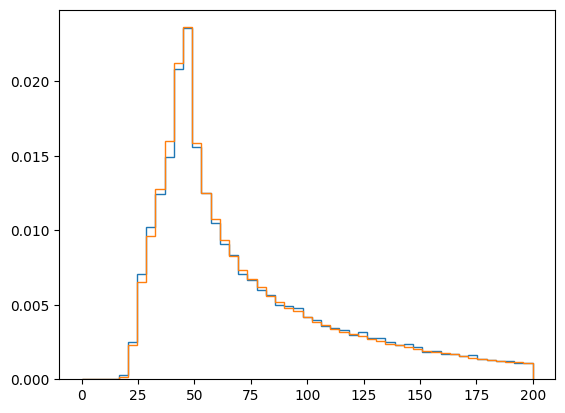

In [8]:
plt.hist(sample_pp[:,0], bins=np.linspace(0,200,50), density=True, histtype="step")
plt.hist(test_data[:,0], bins=np.linspace(0,200,50), density=True, histtype="step")